In [1]:
import datetime as dt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from viresclient import SwarmRequest
import chaosmagpy as cp  # v0.1

# Get a day of model evaluations from VirES
# 01/01/2017

In [2]:
request = SwarmRequest()
request.set_collection("SW_OPER_MAGA_LR_1B")
request.set_products(measurements=["B_NEC", "F"],
                     models=[
                         "CHAOS-6-Core",
                         "CHAOS-6-Static",
                         "CHAOS-6-Combined",
                         "CHAOS-6-MMA-Primary",
                         "CHAOS-6-MMA-Secondary",
                     ],
                     sampling_step="PT30S")
ds = request.get_between(
    start_time=dt.datetime(2017,1,1),
    end_time=dt.datetime(2017,1,2)
).as_xarray()

ds

[1/1] Processing:  100%|██████████|  [ Elapsed: 00:03, Remaining: 00:00 ]
      Downloading: 100%|██████████|  [ Elapsed: 00:00, Remaining: 00:00 ] (0.664MB)


<xarray.Dataset>
Dimensions:                      (Timestamp: 2880, dim: 3)
Coordinates:
  * Timestamp                    (Timestamp) datetime64[ns] 2017-01-01 ... 2017-01-01T23:59:30
Dimensions without coordinates: dim
Data variables:
    Spacecraft                   (Timestamp) <U1 'A' 'A' 'A' 'A' ... 'A' 'A' 'A'
    Latitude                     (Timestamp) float64 68.86 70.77 ... -33.25
    Longitude                    (Timestamp) float64 137.4 138.0 ... -48.99
    Radius                       (Timestamp) float64 6.812e+06 ... 6.826e+06
    B_NEC                        (Timestamp, dim) float64 0.0 0.0 ... -1.348e+04
    B_NEC_CHAOS-6-Core           (Timestamp, dim) float64 8.136e+03 ... -1.347e+04
    B_NEC_CHAOS-6-Static         (Timestamp, dim) float64 2.912 2.503 ... 0.8466
    B_NEC_CHAOS-6-Combined       (Timestamp, dim) float64 8.139e+03 ... -1.346e+04
    B_NEC_CHAOS-6-MMA-Primary    (Timestamp, dim) float64 -12.96 ... -13.29
    B_NEC_CHAOS-6-MMA-Secondary  (Timestamp, dim) 

# Functions to help use chaosmagpy

Get the CHAOS model .mat file at http://www.spacecenter.dk/files/magnetic-models/CHAOS-6/

`!wget http://www.spacecenter.dk/files/magnetic-models/CHAOS-6/CHAOS-6-x9.mat`

In [3]:
chaos_model = cp.load_CHAOS_matfile('CHAOS-6-x9.mat')

In [4]:
def datetimeindex_to_mjd2000(dti):
    """Convert a pandas datetime index to MJD2000
    
    Convert an array to a dti like this:
    pd.core.indexes.datetimes.DatetimeIndex(np.array([dt.datetime(2017,1,1),]))
    """
    if type(dti) is not pd.core.indexes.datetimes.DatetimeIndex:
        raise Exception("Input should be a pandas DatetimeIndex")
    return dti.to_julian_date() - 2400000.5 - 51544

def rtp2NEC(B_rtp):
    """Change an array from rtp to NEC frame
    """
    if B_rtp.shape[1] != 3:
        raise Exception("B_rtp is not the right shape")
    return np.stack((-B_rtp[:, 1], B_rtp[:, 2], -B_rtp[:, 0])).T

def get_chaos_tdep_NEC(times_mjd2000, radius, theta, phi, nmax=20):
    coeffs = chaos_model.synth_coeffs_tdep(
        nmax=nmax,
        time=times_mjd2000
    )
    B_radius, B_theta, B_phi = cp.model_utils.synth_values(
            coeffs, radius, theta, phi, nmax=nmax, source='internal'
    )
    B_NEC = rtp2NEC(np.stack((B_radius, B_theta, B_phi)).T)
    return B_NEC

def get_chaos_static_NEC(times_mjd2000, radius, theta, phi):
    coeffs_static = chaos_model.synth_coeffs_static()
    B_radius, B_theta, B_phi = cp.model_utils.synth_values(
            coeffs_static, radius, theta, phi
    )
    B_NEC = rtp2NEC(np.stack((B_radius, B_theta, B_phi)).T)
    return B_NEC

def get_chaos_mma_NEC(times_mjd2000=None, radius=None, theta=None, phi=None,
                      source=None):
    B_radius = np.zeros(times_mjd2000.shape)
    B_theta = np.zeros(times_mjd2000.shape)
    B_phi = np.zeros(times_mjd2000.shape)
    for synth_coeffs in (chaos_model.synth_coeffs_sm, chaos_model.synth_coeffs_gsm):
        coeffs = synth_coeffs(times_mjd2000, source=source)
        B_r, B_t, B_p = cp.model_utils.synth_values(
            coeffs, radius, theta, phi, source=source
        )
        B_radius += B_r
        B_theta += B_t
        B_phi += B_p
    return rtp2NEC(np.stack((B_radius, B_theta, B_phi)).T)

# Use chaosmagpy to evaluate CHAOS models and add them to the dataset

In [5]:
times_mjd2000 = datetimeindex_to_mjd2000(ds.indexes["Timestamp"]).values
theta = 90 - ds["Latitude"]
phi = ds["Longitude"] % 360
radius = ds["Radius"] / 1e3

ds["B_NEC_CHAOS-6-Core-PY"] = (
    ("Timestamp","dim"), 
    get_chaos_tdep_NEC(times_mjd2000, radius, theta, phi)
)
ds["B_NEC_CHAOS-6-Static-PY"] = (
    ("Timestamp","dim"),
    get_chaos_static_NEC(times_mjd2000, radius, theta, phi)
)
ds["B_NEC_CHAOS-6-MMA-Primary-PY"] = (
    ("Timestamp","dim"),
    get_chaos_mma_NEC(times_mjd2000, radius, theta, phi, "external")
)
ds["B_NEC_CHAOS-6-MMA-Secondary-PY"] = (
    ("Timestamp","dim"),
    get_chaos_mma_NEC(times_mjd2000, radius, theta, phi, "internal")
)

ds["B_NEC_CHAOS-6-MMA"] = ds["B_NEC_CHAOS-6-MMA-Primary"] + ds["B_NEC_CHAOS-6-MMA-Secondary"]
ds["B_NEC_CHAOS-6-MMA-PY"] = ds["B_NEC_CHAOS-6-MMA-Primary-PY"] + ds["B_NEC_CHAOS-6-MMA-Secondary-PY"]

ds

<xarray.Dataset>
Dimensions:                         (Timestamp: 2880, dim: 3)
Coordinates:
  * Timestamp                       (Timestamp) datetime64[ns] 2017-01-01 ... 2017-01-01T23:59:30
Dimensions without coordinates: dim
Data variables:
    Spacecraft                      (Timestamp) <U1 'A' 'A' 'A' ... 'A' 'A' 'A'
    Latitude                        (Timestamp) float64 68.86 70.77 ... -33.25
    Longitude                       (Timestamp) float64 137.4 138.0 ... -48.99
    Radius                          (Timestamp) float64 6.812e+06 ... 6.826e+06
    B_NEC                           (Timestamp, dim) float64 0.0 ... -1.348e+04
    B_NEC_CHAOS-6-Core              (Timestamp, dim) float64 8.136e+03 ... -1.347e+04
    B_NEC_CHAOS-6-Static            (Timestamp, dim) float64 2.912 ... 0.8466
    B_NEC_CHAOS-6-Combined          (Timestamp, dim) float64 8.139e+03 ... -1.346e+04
    B_NEC_CHAOS-6-MMA-Primary       (Timestamp, dim) float64 -12.96 ... -13.29
    B_NEC_CHAOS-6-MMA-Secondary

# Plot the difference between model values from chaosmagpy and from VirES

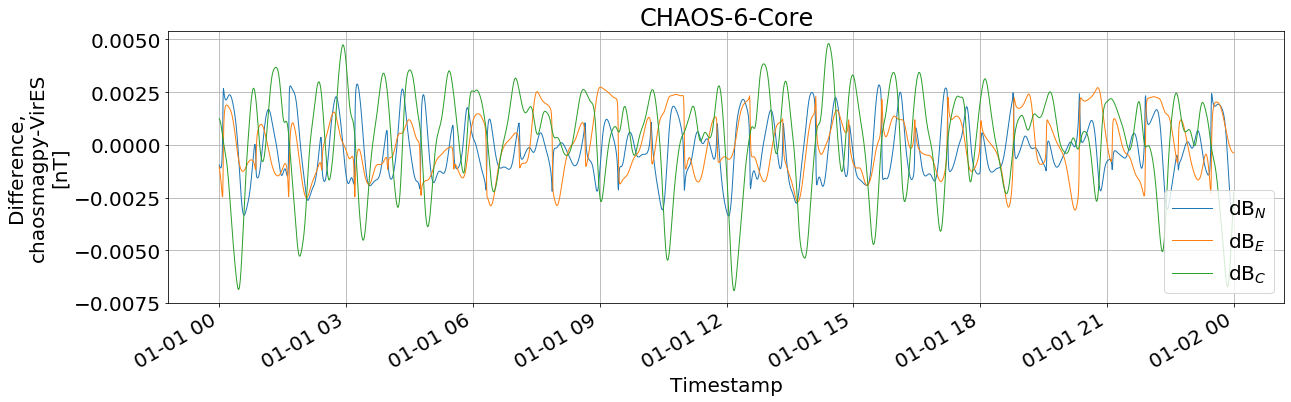

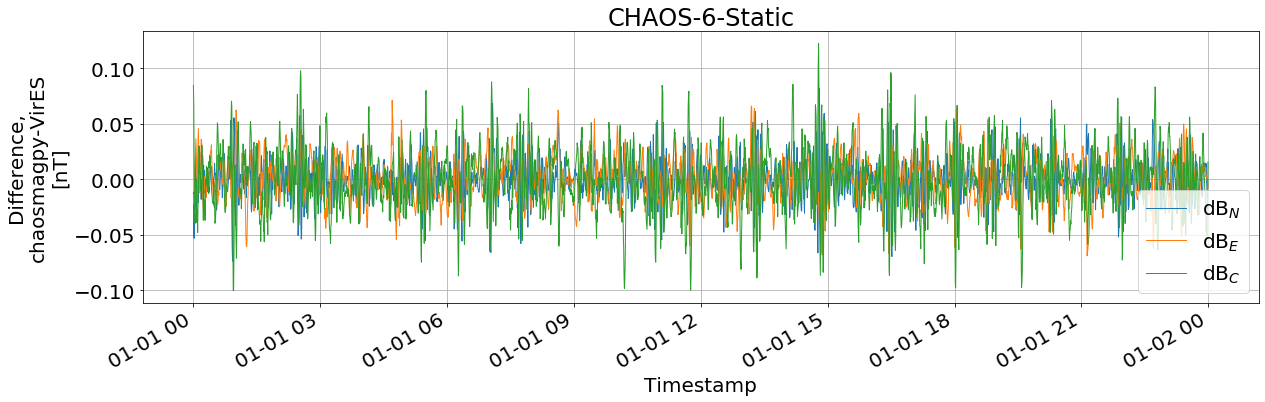

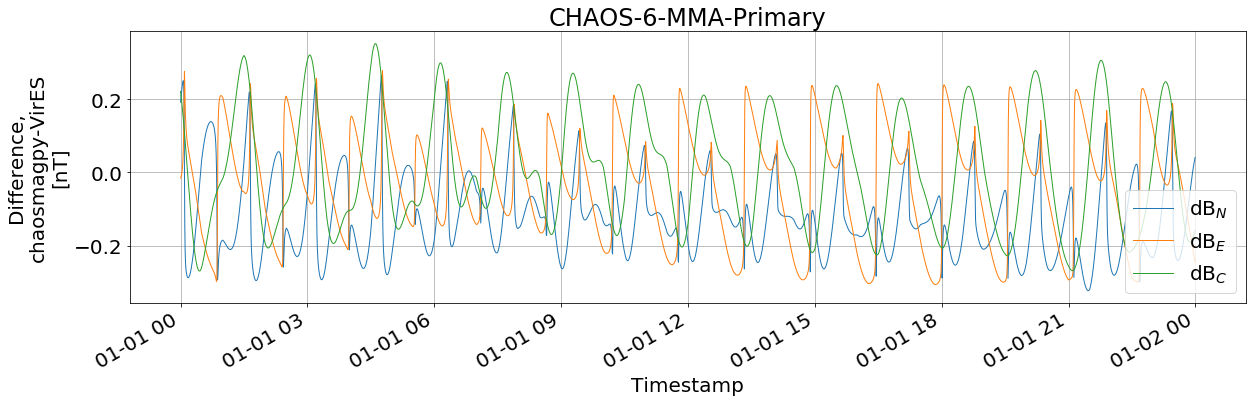

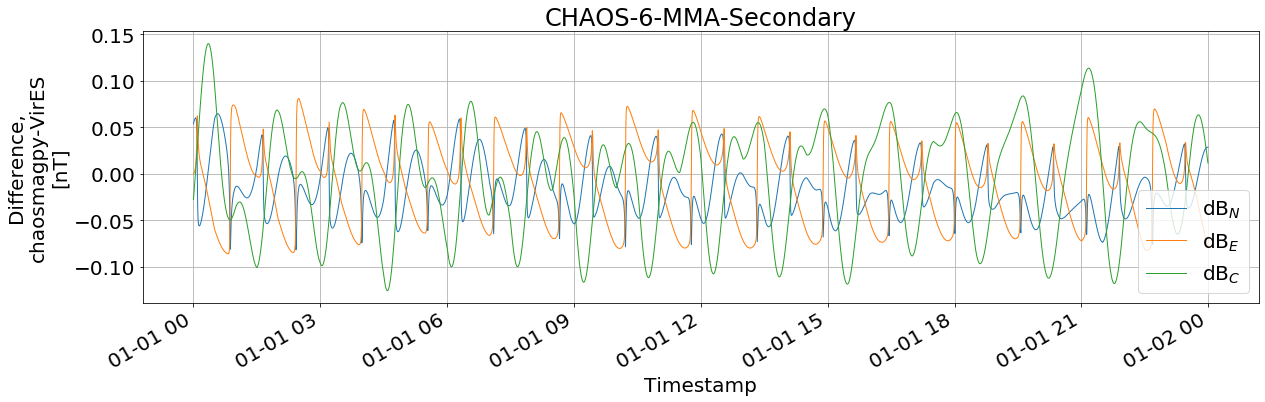

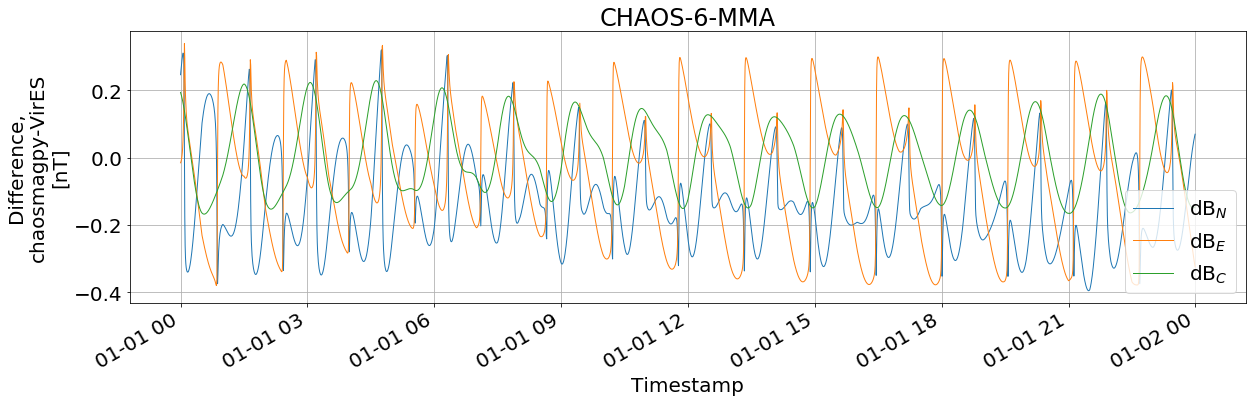

In [7]:
plt.rcParams["font.size"] = 20

for mod in ("CHAOS-6-Core","CHAOS-6-Static", "CHAOS-6-MMA-Primary", "CHAOS-6-MMA-Secondary", "CHAOS-6-MMA"):
    plt.figure(figsize=(20,5))
    for i, label in enumerate(["dB$_N$", "dB$_E$", "dB$_C$"]):
        (ds[f"B_NEC_{mod}-PY"] - ds[f"B_NEC_{mod}"])[:,i].plot(label=label, linewidth=1)
    plt.title(mod)
    plt.ylabel("Difference,\nchaosmagpy-VirES\n[nT]")
    plt.legend(loc="lower right"); plt.grid();